# 预处理图像

In [1]:
import cv2
import numpy as np


def union_graph_size(image, targe_width=500, target_height=500):
    height, width = image.shape[:2]
    scale = min(targe_width / width, target_height / height)  # 放缩比例
    new_width = int(width * scale)
    new_height = int(height * scale)
    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    pad_image = np.ones((target_height, targe_width, 3), dtype=np.uint8) * 255
    x = (targe_width-new_width) // 2
    y = (target_height-new_height) // 2
    pad_image[y:y+new_height, x: x+new_width] = image
    return pad_image


def remove_noise(binary_image, use_blur, kernel_size1, kernel_size2=3):  # 去噪声点
    kernel = np.ones((kernel_size1, kernel_size1), np.uint8)
    # 使用腐蚀膨胀法消除噪声
    image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    # 使用中值滤波消除噪声
    if use_blur:
        image = cv2.medianBlur(image, kernel_size2)
    return image


def pre_process_roomsort(n):  # 用来预处理来源于roomsort的数据
    for i in range(1, n+1):
        image = cv2.imread(r"crude_room_dataset/g" + str(i) + ".jpg")
        if image is not None:
            image = union_graph_size(image, 500, 500)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            _, binary_image = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
            binary_image = remove_noise(binary_image, False, 4, kernel_size2=5)
            cv2.imwrite(r'feature_graph/g'+str(i)+".jpg", binary_image)
            cv2.imwrite(r'resize_graph/g' + str(i) + ".jpg", image)
        else:
            print("NO such image!")


# 噪声多单独处理图像的函数
def detail_process(path, out_put_name=None, width=500, height=500, blur=False, kernel_size1=3, kernel_size2=3, max_color=160):
    image = cv2.imread(path)
    image = union_graph_size(image, width, height)
    cv2.imwrite('resize_graph/'+str(out_put_name)+".jpg", image)
    low_color = np.array([0, 0, 0])
    up_color = np.array([max_color, max_color, max_color])
    color_mark = cv2.inRange(image, low_color, up_color)  # 创建掩码。查找颜色范围内的像素
    image[color_mark != 0] = [0, 0, 0]  # 将一定深度的颜色都转为黑色！
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 灰度图
    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)  # 黑白图
    de_noise_image = remove_noise(binary_image, blur, kernel_size1, kernel_size2)  # 去噪图
    # de_noise_image = binary_image
    if out_put_name is not None:
        cv2.imwrite('feature_graph/' + str(out_put_name) + ".jpg", de_noise_image)
    return de_noise_image


if __name__ == "__main__":
    pre_process_roomsort(99)  # g71/35/39/47
    detail_process("crude_room_dataset/g47.jpg", 'g47', blur=False, kernel_size1=3, kernel_size2=3, max_color=50)
    for i in [35, 39, 71]:
        detail_process(f"crude_room_dataset/g{i}.jpg", f'g{i}', blur=False, kernel_size1=7, kernel_size2=3, max_color=50)
 

# 传统方法绘制边界

In [2]:
import cv2
import numpy as np
from skimage.morphology import skeletonize  # pip install scikit-image


def complete(image_path, output_name, rho=1.5, theta=np.pi / 120, threshold=15, minLineLength=0.1, maxLineGap=50, width=2, show=False):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY_INV)
    skeleton = skeletonize(binary // 255).astype(np.uint8) * 255  # 骨架化处理
    # 使用霍夫变换检测线条
    lines = cv2.HoughLinesP(skeleton, rho=rho, theta=theta, threshold=threshold,
                            minLineLength=minLineLength, maxLineGap=maxLineGap)
    line_image = image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 0), width)
    # cv2.imshow('Skeleton', skeleton)
    cv2.imwrite(f"sealed_graph/{output_name}.jpg", line_image)
    if show:
        cv2.imshow('Detected Lines', line_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


def get_zone(image, output_name=None, save=False, min_area=10, show=False, width=3, slid=False, dx=3, dy=3):  # 从封闭图中提取并绘制区域
    if type(image) == str:
        image = cv2.imread(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    output = np.ones_like(image)*255
    # print(len(contours))
    for i, contour in enumerate(contours):
        if hierarchy[0][i][3] != -1:  # 检查轮廓是否是内部轮廓
            area = cv2.contourArea(contour)
            if area > min_area:
                cv2.drawContours(output, [contour], -1, (0, 0, 255), int(width))
    if slid:
        output = sliding(output, dx, dy)
    if show:
        cv2.imshow('Internal Contours', output)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    if output_name is not None and save:
        cv2.imwrite("zone_area/"+str(output_name)+".jpg", output)
    return output


def draw_zone(zone_image, image, show=False, save=False, output_name=None):  # 在原图上绘制
    if type(image) == str:
        image = cv2.imread(image)
    if type(zone_image) == str:
        zone_image = cv2.imread(zone_image)
    # print(zone_image.shape)
    for x in range(zone_image.shape[0]):
        for y in range(zone_image.shape[1]):
            if np.any(zone_image[x][y][:] != [255, 255, 255]):  # 不是空白！
                image[x][y] = zone_image[x][y]
                # print(x, "    ", y)
    if show:
        cv2.imshow('Zone Area', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    if save and output_name is not None:
        cv2.imwrite('graph_with_zone/'+str(output_name)+'.jpg', image)
    return image


def sliding(image, dx=3, dy=3):
    if type(image) == str:
        image = cv2.imread(image)
    slided_image = np.ones_like(image)*255
    slided_image[:image.shape[0]-dx, :image.shape[1]-dy, :] = image[dx:image.shape[0], dy:image.shape[1], :]
    return slided_image


def complete_all(n):
    list1 = [7, 10, 16, 20, 24, 25, 27, 32, 34, 35, 36, 39, 42, 43, 44, 50, 54, 78, 93]
    for i in range(1, n+1):
        if i not in list1:
            complete('feature_graph/g' + str(i) + '.jpg', f"g{i}", width=3)
        else:
            complete(f'feature_graph/g{i}.jpg', f'g{i}', rho=1, theta=np.pi / 120, threshold=10, minLineLength=0.1,
                     maxLineGap=49, width=3)
    complete('feature_graph/g35.jpg', 'g35', rho=1.5, theta=np.pi / 120, threshold=10, minLineLength=0.1, maxLineGap=54,
             width=3)
    complete('feature_graph/g39.jpg', 'g39', rho=1.5, theta=np.pi / 120, threshold=15, minLineLength=0.1, maxLineGap=80,
             width=3)
    complete('feature_graph/g52.jpg', 'g52', rho=1, theta=np.pi / 120, threshold=15, minLineLength=0.1, maxLineGap=50,
             width=2)
    complete('feature_graph/g55.jpg', 'g55', rho=2, theta=np.pi / 120, threshold=15, minLineLength=0.1, maxLineGap=50,
             width=3)
    complete('feature_graph/g80.jpg', 'g80', rho=2, theta=np.pi / 120, threshold=15, minLineLength=0.1, maxLineGap=50,
             width=3)
    complete('feature_graph/g81.jpg', 'g81', rho=0.8, theta=np.pi / 120, threshold=10, minLineLength=0.1, maxLineGap=50,
             width=3)
    complete('feature_graph/g97.jpg', 'g97', rho=0.8, theta=np.pi / 120, threshold=15, minLineLength=0.1, maxLineGap=55,
             width=2)


def draw_all_roomsort(n, start=1):
    # g35/39/42/43/44/47不需要偏移
    not_slid = [35, 39, 41, 47, 71]
    for i in range(start, n + 1):
        if i not in not_slid:  # 需要进行平移的操作
            draw_zone(
                get_zone(
                    get_zone(f"sealed_graph/g{i}.jpg", show=False, width=2), output_name=f'g{i}', save=False,
                    show=False, min_area=4500, width=2, slid=True),
                f'resize_graph/g{i}.jpg', show=False, save=True, output_name=f"g{i}")
        else:
            draw_zone(
                get_zone(get_zone(f"sealed_graph/g{i}.jpg", show=False, width=2), output_name=f'g{i}', save=False,
                         show=False, min_area=4500, width=2),
                f'resize_graph/g{i}.jpg', show=False, save=True, output_name=f"g{i}")


def remove_noise2(image, output=None,  kernel=3, close=False):
    kernel1 = np.ones((kernel, kernel), dtype=np.uint8)
    if type(image) == str:
        image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 灰度图
    _, binary_image = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
    # print(np.unique_counts(binary_image))
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel1)
    if close:
        binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel1)
    if output is not None:
        cv2.imwrite(f'sealed_graph/{output}.jpg', binary_image)
    # print(np.unique_counts(binary_image))
    '''cv2.imshow('image', binary_image)
    cv2.waitKey()
    cv2.destroyAllWindows()'''
    

if __name__ == "__main__":
    complete_all(99)
    draw_all_roomsort(99)
    for i in range(1, 100):
        remove_noise2(f'sealed_graph/g{i}.jpg', f'g{i}', kernel=7)


# 定义网络和数据集构建

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
import os
import cv2
import numpy as np
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # 输入是CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        # 编码层
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        # 解码层
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        # 输出层
        self.outc = OutConv(64, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return self.sigmoid(logits)


def load_dataset(input_directory=None, label_directory=None):
    input = list()
    label = list()
    # print(os.listdir(input_directory))
    i = 1
    for file in os.listdir(input_directory):  # 加载输入
        image = cv2.imread(input_directory + '/' + file)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            _, image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
            image = (image / 255.0).astype('float32')  # 二值化为是否为边界
            '''if i == 1:
                i += 1
                print(np.unique_counts(image))
                cv2.imshow('image', image)
                cv2.waitKey(0)
                cv2.destroyAllWindows()'''
            image = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)
            input.append(image)
    for file in os.listdir(label_directory):  # 加载标签
        image = cv2.imread(label_directory + '/' + file)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            _, image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)
            image = (abs(image / 255 - 1)).astype('float32')  # 二值化为是否为边界
            '''if i == 2:
                print(np.unique_counts(image))
                i+=1
                cv2.imshow('image', image)
                cv2.waitKey(0)
                cv2.destroyAllWindows()'''
            image = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)
            label.append(image)

    input_data = torch.cat(input, dim=0)
    label_data = torch.cat(label, dim=0)
    print(input_data.shape, label_data.shape)
    dataset = TensorDataset(input_data, label_data)  # 返回数据集
    return input_data, label_data, dataset


def Unet_train(model, dataloader, train=False, lr=0.0001, epochs=20, save_path='model.pth'):
    if not os.path.exists(save_path) or train:
        loss_list = []
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(device)
        model.to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        for epoch in range(epochs):
            epoch_loss = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(dataloader)
            loss_list.append(avg_loss)
            print(f"Epoch [{epoch + 1}/{epochs}], Average Loss: {avg_loss}")
        # 保存模型参数
        torch.save(model.state_dict(), save_path)
        print(f"model is saved to {save_path}")
        return loss_list
    else:
        return False


def get_test_example(image_path, show=False, kernel_size1=3, blur=False, max_color=200):
    reshape_image = union_graph_size(cv2.imread(image_path))
    image = detail_process(image_path, kernel_size1=kernel_size1, blur=blur, max_color=max_color).astype('float32')/255.0
    if show:
        cv2.imshow('TEST IMAGE', image)
        cv2.waitKey()
        cv2.destroyAllWindows()
    image = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)
    return image, reshape_image


def My_find_1(image, width=0):  # 用来找到边界
    id_list = list()
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if image[x][y] >= 0.01:
                for i in range(-width, width+1):
                    for j in range(-width, width+1):
                        id_list.append([x+i, y+j])
    return id_list


def draw_predict_zone(output, reshape_image):
    reshape_image1 = reshape_image.copy()
    output = output.squeeze(0).squeeze(0)  # 降维
    # print(type(output))
    output = output.detach().numpy()
    '''print(output.shape)
    print(np.unique_counts(output))'''
    id = My_find_1(output)
    print(len(id))
    sealed_image = np.ones_like(reshape_image) * 255
    for [x, y] in id:
        reshape_image1[x][y][:] = [0, 0, 0]
        sealed_image[x][y][:] = [0, 0, 0]
    return reshape_image1, sealed_image  # 返回绘制了边界的图片和被封闭起来的图片


if __name__ == "__main__":
    load_dataset('feature_graph', 'sealed_graph')



torch.Size([99, 1, 500, 500]) torch.Size([99, 1, 500, 500])


# 训练网络

In [4]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import cv2
import os

torch.cuda.empty_cache()
_, _, dataset = load_dataset('feature_graph', 'sealed_graph')
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
model = UNet()
path = 'model.pth'
if os.path.exists(path):
    model.load_state_dict(torch.load(path))
loss_list = Unet_train(model, dataloader, save_path=path, epochs=200, lr=0.0001)
model.load_state_dict(torch.load(path))



torch.Size([99, 1, 500, 500]) torch.Size([99, 1, 500, 500])
cuda


/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/200], Average Loss: 0.5406822287119352
Epoch [2/200], Average Loss: 0.48137057056793797
Epoch [3/200], Average Loss: 0.448855269413728
Epoch [4/200], Average Loss: 0.4276931583881378
Epoch [5/200], Average Loss: 0.41141998309355515
Epoch [6/200], Average Loss: 0.39852532973656285
Epoch [7/200], Average Loss: 0.38738606984798724
Epoch [8/200], Average Loss: 0.3777773632453038
Epoch [9/200], Average Loss: 0.3690716532560495
Epoch [10/200], Average Loss: 0.3617000969556662
Epoch [11/200], Average Loss: 0.35478681325912476
Epoch [12/200], Average Loss: 0.3474260683243091
Epoch [13/200], Average Loss: 0.340916993526312
Epoch [14/200], Average Loss: 0.3346699063594525
Epoch [15/200], Average Loss: 0.32869688822672916
Epoch [16/200], Average Loss: 0.3231006700258989
Epoch [17/200], Average Loss: 0.317553379214727
Epoch [18/200], Average Loss: 0.31265246409636277
Epoch [19/200], Average Loss: 0.3075812424604709
Epoch [20/200], Average Loss: 0.3026964802008409
Epoch [21/200], Average L

<All keys matched successfully>

# 绘制损失函数曲线

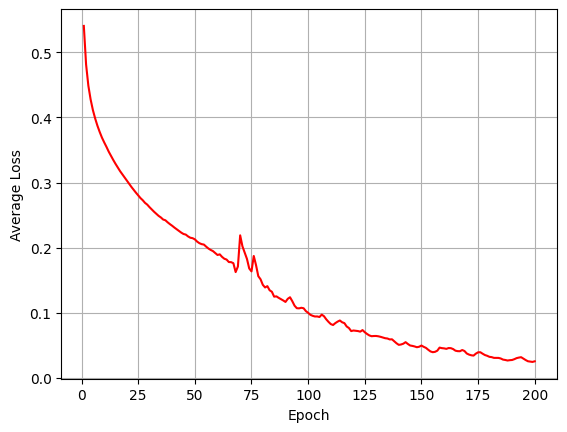

In [5]:
x = list(range(1, len(loss_list)+1))
plt.plot(x, loss_list, color='r')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid()
plt.show()

# 测试模型边界划分

In [20]:
model.load_state_dict(torch.load(path))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [21]:
def my_test(test_path, kernel, title="image"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_image, reshape_image = get_test_example(test_path, kernel_size1=kernel, blur=False, max_color=120)
    test_image = test_image.to(device)
    with torch.no_grad():
        output = model(test_image)
    output = output.cpu()
    predict_image, sealed_image = draw_predict_zone(output, reshape_image)
    image = draw_zone(
                get_zone(
                    get_zone(sealed_image, show=False, width=2), output_name=None, save=False,
                    show=False, min_area=1000, width=2, slid=False),
                reshape_image, show=False, save=False, output_name=None)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title(str(title))
    plt.show()

24151


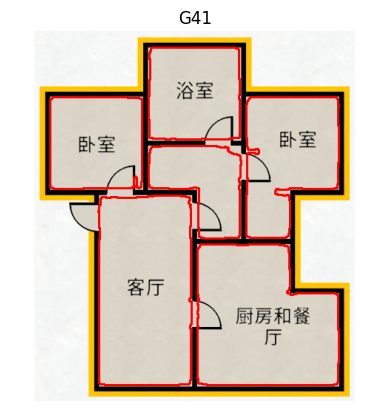

In [22]:
my_test('crude_room_dataset/g41.jpg', 5, "G41")

37821


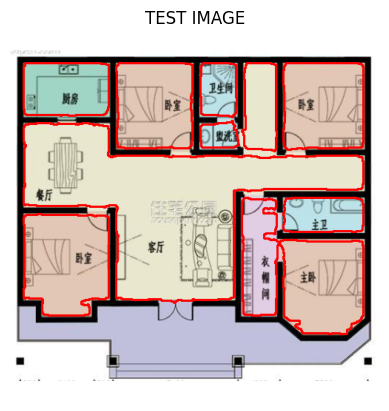

In [23]:
my_test('test.jpg', 7, "TEST IMAGE")